# Comparing Orbital Distributions


In [1]:
using CairoMakie
using Arya
using LilGuys
using CSV, DataFrames


[ Info: Precompiling MakieExt [9d2538b1-6dc1-59b4-904f-de16d60c1784] (cache misses: wrong dep version loaded (2), incompatible header (10))


In [3]:
using PyFITS

In [4]:
using HDF5

In [13]:
using Printf

In [14]:
using StatsBase

In [22]:
CairoMakie.activate!(type=:png)

In [5]:
function read_traj(name)
    local positions, velocities, times
    
    h5open("$name/trajectory.hdf5", "r") do f
        positions = f["positions"][:, :, :]
        velocities = f["velocities"][:, :, :]
        times = -f["times"][:]
    end

    return positions, velocities, times
end

read_traj (generic function with 1 method)

In [6]:
function read_lmc_traj(name)
    
    # loads in trajectory of lmc in Vasiliev 2021
    lmc_file = "$name/lmc_traj.csv"
    lmc_traj = CSV.read(lmc_file, DataFrame)
    
    pos = reshape([lmc_traj.x lmc_traj.y lmc_traj.z]', (3, 1, :))
    vel = reshape([lmc_traj.v_x lmc_traj.v_y lmc_traj.v_z]', (3, 1, :))

    return pos, vel, -(lmc_traj.time)
end

read_lmc_traj (generic function with 1 method)

In [7]:
function subtract_traj(traja, trajb)
    if !isapprox(traja[3], trajb[3], atol=1e-3)
        println(extrema(traja[3]), " ", diff(traja[3])[1])
        println(extrema(trajb[3]), " ", diff(trajb[3])[1])
        error("trajectories do not match")
    end

    return traja[1] .- trajb[1], traja[2] .- trajb[2], traja[3]
end

subtract_traj (generic function with 1 method)

In [8]:
function read_distribution(name)
    return read_fits(joinpath(name, "peris_apos.fits"))
end

read_distribution (generic function with 1 method)

In [46]:
plot_labels = Dict(
    "pericentre" => "pericentre / kpc",
    "peri_lmc" => "perilmc / kpc",
    "apocentre" => "apocentre / kpc",
    "t_last_peri_lmc" => "time of last LMC peri",
    "t_last_peri" => "time of last peri",
    )

Dict{String, String} with 5 entries:
  "t_last_peri_lmc" => "time of last LMC peri"
  "t_last_peri"     => "time of last peri"
  "peri_lmc"        => "perilmc / kpc"
  "apocentre"       => "apocentre / kpc"
  "pericentre"      => "pericentre / kpc"

In [10]:
function compare_peris(families; x="pericentre", legend_position=:lt)
	fig = Figure()
	ax = Axis(fig[1, 1],
		xlabel = plot_labels[x],
		ylabel = "pdf",
	)

    for (label, df) in families
    	bins, counts, err = LilGuys.histogram(df[:, x], normalization=:pdf)
    	lines!(midpoints(bins), counts, label=label)
    end

    axislegend(position=legend_position)

	fig
end

compare_peris (generic function with 1 method)

In [11]:
function compare_t_last_peris(families, legend_position=:lt)
    
	fig = Figure()
	ax = Axis(fig[1, 1],
		xlabel = "time since pericentre / Gyr",
		ylabel = "pdf"
	)

    for (label, df) in families
    	bins, counts, err = LilGuys.histogram(df.t_last_peri, normalization=:pdf)
    	lines!(midpoints(bins), counts, label=label)
    end

    axislegend()

	fig
end

compare_t_last_peris (generic function with 2 methods)

In [12]:
function compare_apos(families)
    
	fig = Figure()
	ax = Axis(fig[1, 1],
		xlabel = "apocentre / kpc",
		ylabel = "pdf"
	)

    for (label, df) in families
    	bins, counts, err = LilGuys.histogram(df.apocentre, normalization=:pdf)
    	lines!(midpoints(bins), counts, label=label)
    end

    axislegend()

	fig
end

compare_apos (generic function with 1 method)

In [15]:
function print_uncertanty(label, x)
    @printf "%16s%12.2f [%0.2f %0.2f] [[%0.2f %0.2f]]\n" label quantile(x, [0.5, 0.16, 0.84, 0.0014, 0.9986])...
end

print_uncertanty (generic function with 1 method)

In [16]:
function compare_stats(families)
    println("pericentre")
    
    for (label, df) in families
        print_uncertanty(label, df.pericentre)
    end

    println("t last peri")
    
    for (label, df) in families
        print_uncertanty(label, df.t_last_peri * T2GYR)
    end

    println("peri lmc")

    for (label, df) in families
        if "peri_lmc" ∈ names(df)
            print_uncertanty(label, df.peri_lmc)
        end
    end

    println("peri lmc time")

    for (label, df) in families
        if "peri_lmc" ∈ names(df)
            print_uncertanty(label, df.t_last_peri_lmc * T2GYR)
        end
    end

end

compare_stats (generic function with 1 method)

# Initial scl comparisons

In [18]:
families = [
    "EP20" => read_distribution("EP2020"),
    "+solar lsr sys" => read_distribution("EP2020_frames"),
 #   "all studies" => read_distribution("all_studies"),
    ]

[ Info: astropy table opened
[ Info: astropy table opened


2-element Vector{Pair{String, DataFrame}}:
           "EP20" => 100000×5 DataFrame
    Row │ index   pericentre  apocentre  t_last_peri  t_last_apo 
        │ Int64   Float64     Float64    Float64      Float64    
────────┼────────────────────────────────────────────────────────
      1 │      1     52.9837    99.7656      91.0938     283.115
      2 │      2     55.1508   103.832       96.0107     297.09
      3 │      3     56.1143   106.357       99.1162     305.889
      4 │      4     47.159     98.3722      99.1162     280.01
      5 │      5     54.6712   104.884       99.1162     300.972
      6 │      6     53.6618   102.197       92.9053     290.103
      7 │      7     56.2931   103.356       91.0938     292.949
      8 │      8     55.5476   105.968       98.0811     303.042
      9 │      9     50.7098    98.0766      92.9053     278.975
     10 │     10     52.5955   103.585       98.0811     295.02
     11 │     11     53.4572   101.307       92.1289     286.997
   ⋮   

In [19]:
compare_stats(families)

pericentre
            EP20       53.05 [49.87 56.25] [[43.71 62.61]]
  +solar lsr sys       53.03 [49.84 56.35] [[43.90 62.94]]
t last peri
            EP20        0.45 [0.43 0.47] [[0.39 0.50]]
  +solar lsr sys        0.45 [0.43 0.47] [[0.39 0.50]]
peri lmc
peri lmc time


[ Info: Using default bins of size = 153
[ Info: Using default bins of size = 64


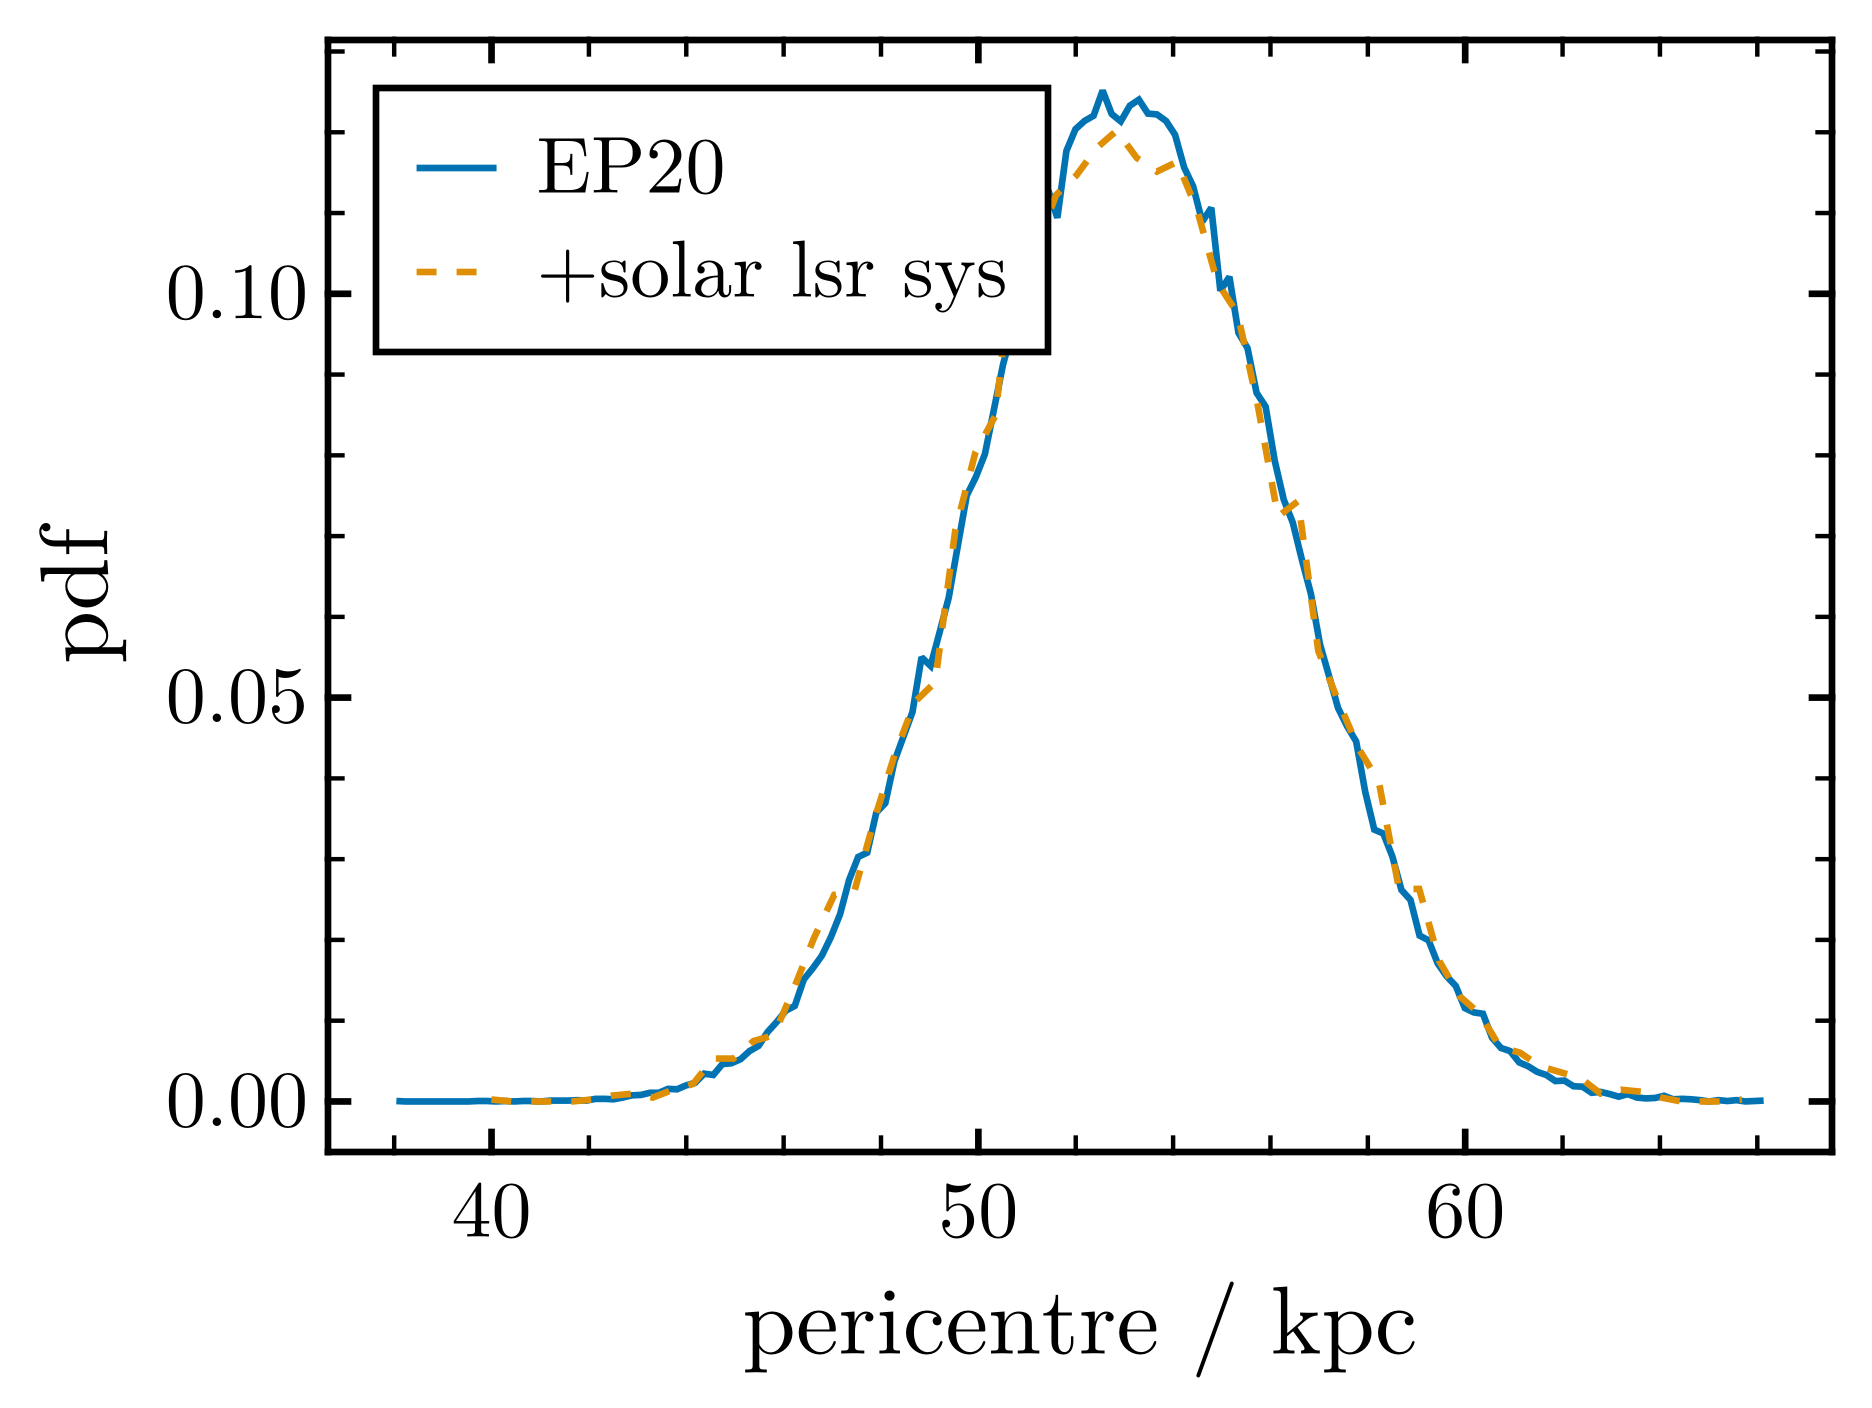

In [20]:
compare_peris(families)

[ Info: Using default bins of size = 154
[ Info: Using default bins of size = 71


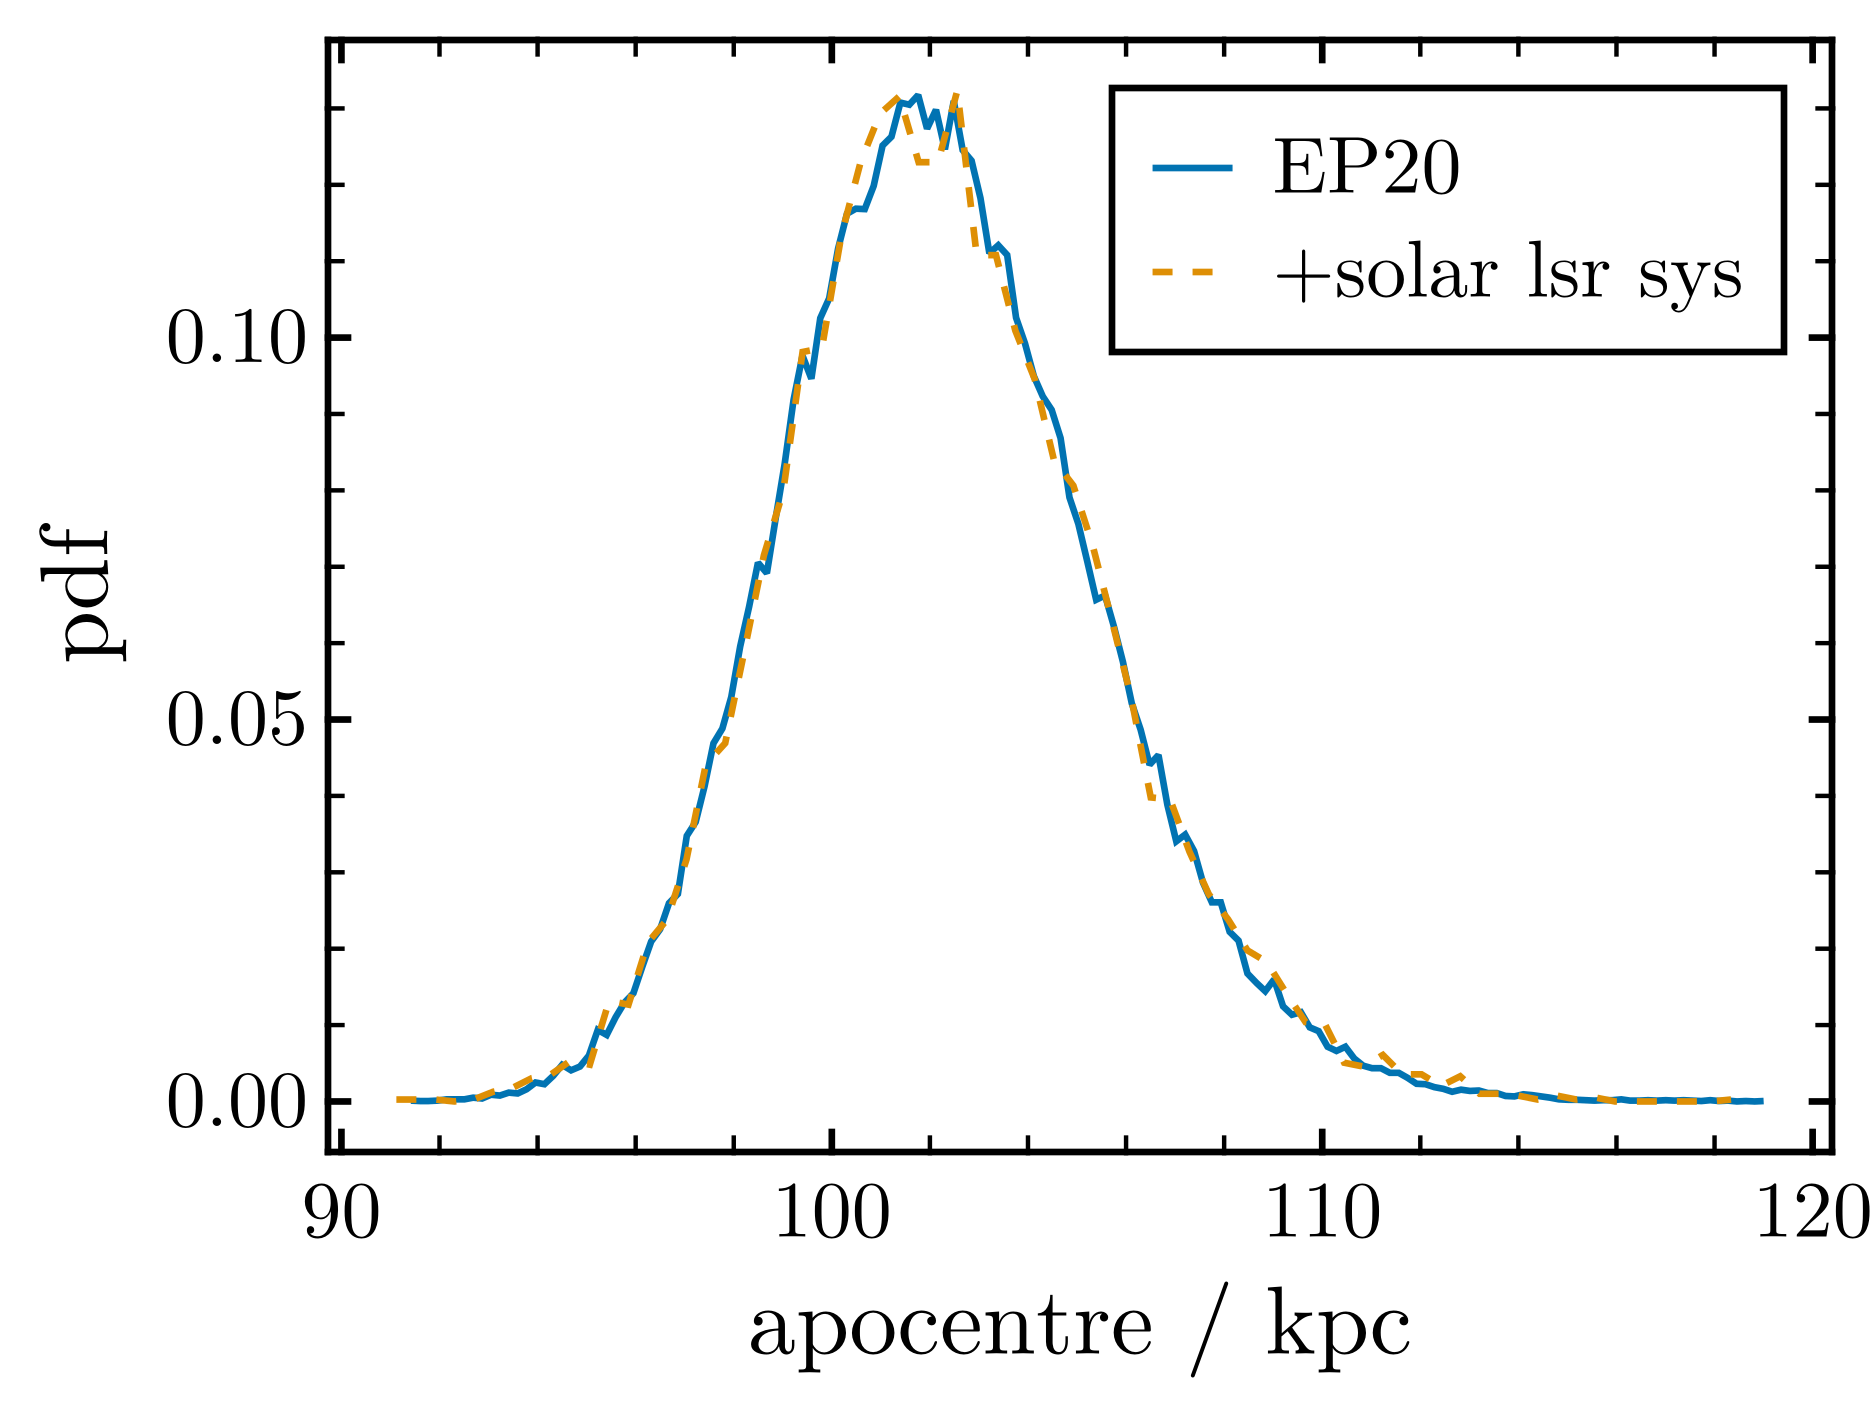

In [21]:
compare_apos(families)

## + trajectories

# LMC

## Trajectories

In [59]:
families = [
    "EP20 (MW only)" => read_distribution("EP2020"),
    "V+24" => read_distribution("vasiliev24_L3M11_2Gyr"),
    "V+24 nolmc" => read_distribution("vasiliev24_M11"),
    "V+24 + frame" => read_distribution("vasiliev24_L3M11_frames"),

    ]

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


4-element Vector{Pair{String, DataFrame}}:
 "EP20 (MW only)" => 100000×5 DataFrame
    Row │ index   pericentre  apocentre  t_last_peri  t_last_apo 
        │ Int64   Float64     Float64    Float64      Float64    
────────┼────────────────────────────────────────────────────────
      1 │      1     52.9837    99.7656      91.0938     283.115
      2 │      2     55.1508   103.832       96.0107     297.09
      3 │      3     56.1143   106.357       99.1162     305.889
      4 │      4     47.159     98.3722      99.1162     280.01
      5 │      5     54.6712   104.884       99.1162     300.972
      6 │      6     53.6618   102.197       92.9053     290.103
      7 │      7     56.2931   103.356       91.0938     292.949
      8 │      8     55.5476   105.968       98.0811     303.042
      9 │      9     50.7098    98.0766      92.9053     278.975
     10 │     10     52.5955   103.585       98.0811     295.02
     11 │     11     53.4572   101.307       92.1289     286.997
   ⋮   

In [60]:
compare_stats(families)

pericentre
  EP20 (MW only)       53.05 [49.87 56.25] [[43.71 62.61]]
            V+24       43.86 [41.19 46.55] [[35.86 52.12]]
      V+24 nolmc       60.41 [57.40 63.41] [[51.18 69.07]]
    V+24 + frame       43.88 [41.18 46.61] [[35.77 52.35]]
t last peri
  EP20 (MW only)        0.45 [0.43 0.47] [[0.39 0.50]]
            V+24        0.38 [0.37 0.39] [[0.34 0.41]]
      V+24 nolmc        0.42 [0.39 0.45] [[0.33 0.50]]
    V+24 + frame        0.38 [0.37 0.39] [[0.34 0.41]]
peri lmc
            V+24       28.67 [27.11 30.25] [[18.13 33.53]]
    V+24 + frame       28.73 [27.20 30.31] [[24.34 33.82]]
peri lmc time
            V+24        0.11 [0.11 0.11] [[0.10 0.12]]
    V+24 + frame        0.11 [0.11 0.11] [[0.10 0.12]]


In [61]:
2/T2GYR

424.1781548250265

[ Info: Using default bins of size = 153
[ Info: Using default bins of size = 149
[ Info: Using default bins of size = 61
[ Info: Using default bins of size = 66


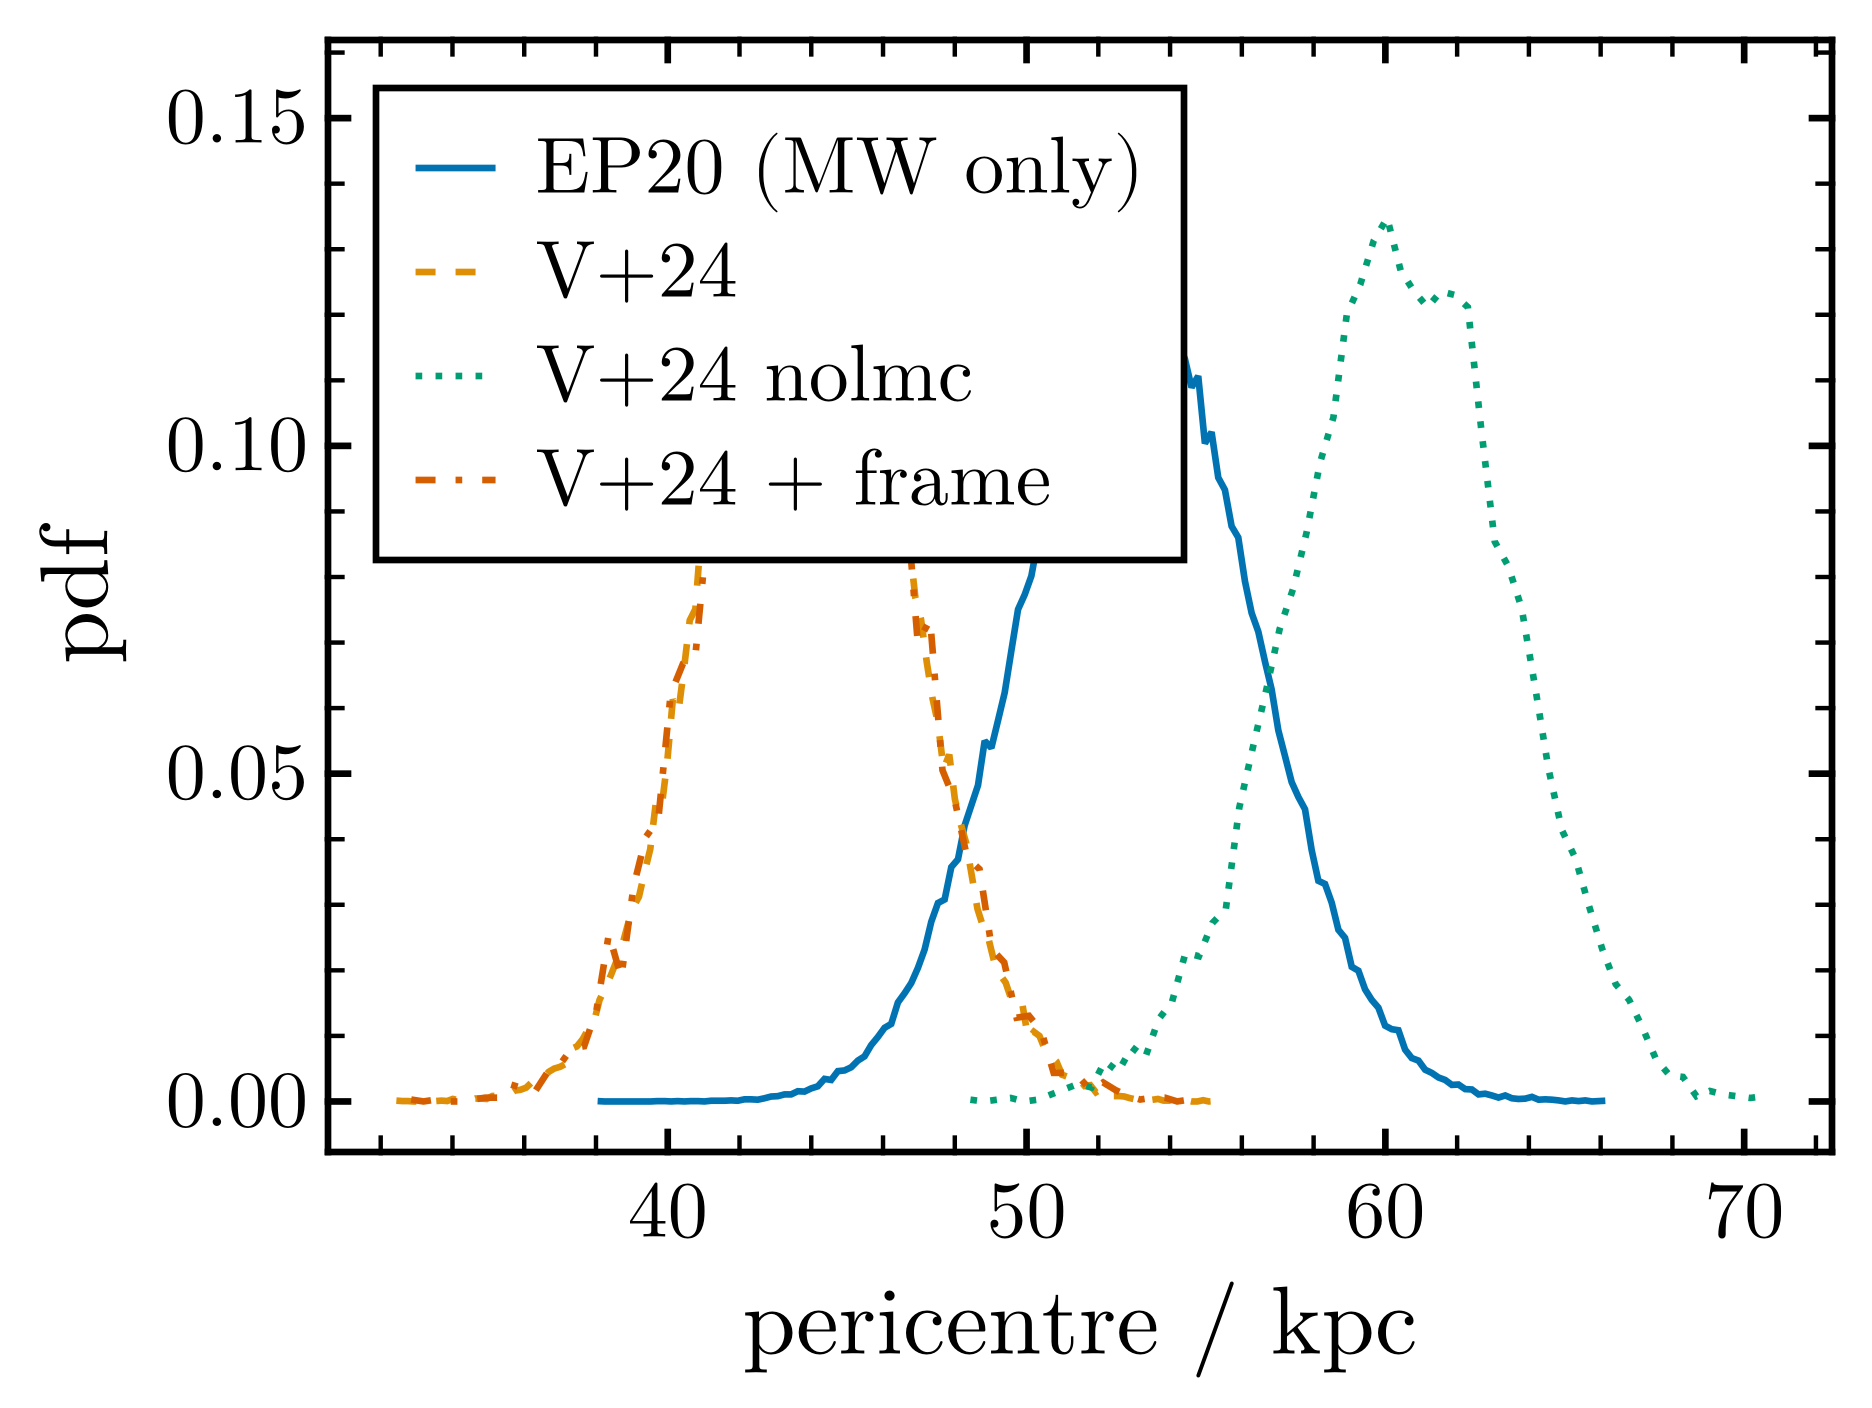

In [62]:
compare_peris(families)

In [66]:
families = [
    "EP20 (MW only)" => read_distribution("EP2020"),
    "V+24 (MW only)" => read_distribution("vasiliev24_M11"),
    "V+24 (MW+LMC)" => read_distribution("vasiliev24_L3M11_2Gyr"),
    ]

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


3-element Vector{Pair{String, DataFrame}}:
 "EP20 (MW only)" => 100000×5 DataFrame
    Row │ index   pericentre  apocentre  t_last_peri  t_last_apo 
        │ Int64   Float64     Float64    Float64      Float64    
────────┼────────────────────────────────────────────────────────
      1 │      1     52.9837    99.7656      91.0938     283.115
      2 │      2     55.1508   103.832       96.0107     297.09
      3 │      3     56.1143   106.357       99.1162     305.889
      4 │      4     47.159     98.3722      99.1162     280.01
      5 │      5     54.6712   104.884       99.1162     300.972
      6 │      6     53.6618   102.197       92.9053     290.103
      7 │      7     56.2931   103.356       91.0938     292.949
      8 │      8     55.5476   105.968       98.0811     303.042
      9 │      9     50.7098    98.0766      92.9053     278.975
     10 │     10     52.5955   103.585       98.0811     295.02
     11 │     11     53.4572   101.307       92.1289     286.997
   ⋮   

In [67]:
compare_stats(families)

pericentre
  EP20 (MW only)       53.05 [49.87 56.25] [[43.71 62.61]]
  V+24 (MW only)       60.41 [57.40 63.41] [[51.18 69.07]]
   V+24 (MW+LMC)       43.86 [41.19 46.55] [[35.86 52.12]]
t last peri
  EP20 (MW only)        0.45 [0.43 0.47] [[0.39 0.50]]
  V+24 (MW only)        0.42 [0.39 0.45] [[0.33 0.50]]
   V+24 (MW+LMC)        0.38 [0.37 0.39] [[0.34 0.41]]
peri lmc
   V+24 (MW+LMC)       28.67 [27.11 30.25] [[18.13 33.53]]
peri lmc time
   V+24 (MW+LMC)        0.11 [0.11 0.11] [[0.10 0.12]]


[ Info: Using default bins of size = 153
[ Info: Using default bins of size = 61
[ Info: Using default bins of size = 149


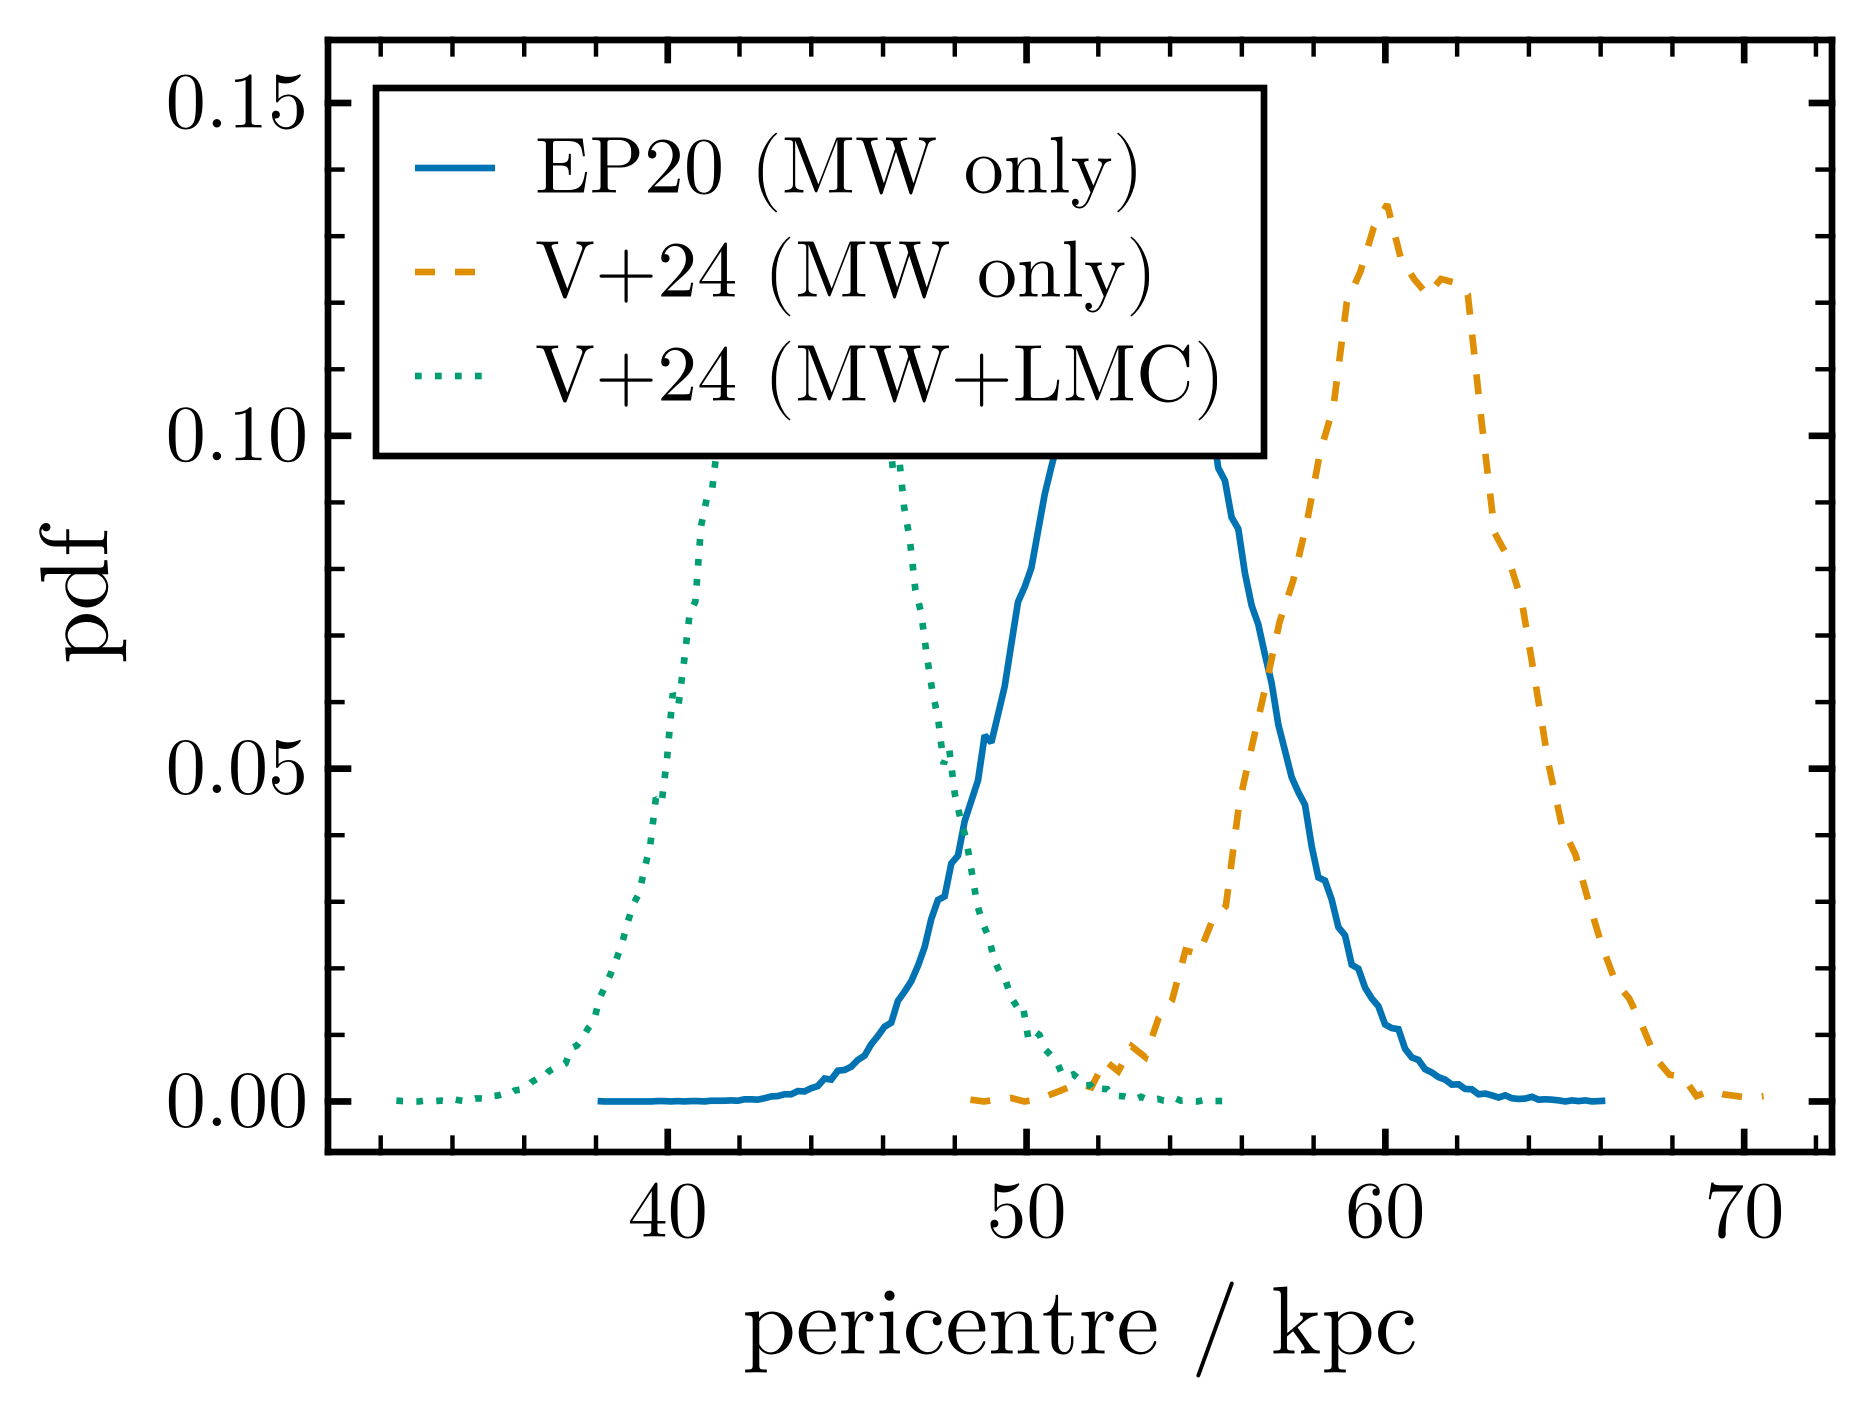

In [68]:
compare_peris(families)

In [69]:
unique(df.t_last_peri)

18-element Vector{Float64}:
 83.0712890625
 78.9306640625
 79.9658203125
 82.0361328125
 74.013671875
 81.0009765625
 76.083984375
 84.1064453125
 77.8955078125
 75.048828125
 77.119140625
 85.91796875
 84.8828125
 86.953125
 72.978515625
 71.943359375
 87.98828125
 70.908203125

In [70]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "time since pericentre / Gyr",
    ylabel = "pericentre",
    limits=(0, nothing, 0, nothing)
)

for (label, df) in families
    scatter!(df.t_last_peri*T2GYR .+ 0.2*T2GYR * randn(length(df.t_last_peri)), df.pericentre, label=label => (; markersize=10), markersize=3, alpha=0.1)
end

df = families[end].second
scatter!(df.t_last_peri_lmc * T2GYR, df.peri_lmc, marker=:odot, label="V+21 (LMC frame)" =>(; markersize=10), markersize=3, alpha=0.1)


axislegend(position=:lt)a

fig

LoadError: UndefVarError: `a` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [80]:
families = [
    "L1.5" => read_distribution("vasiliev_lmc"),
    "L2M10" => read_distribution("vasiliev24_L2M10"),
    "L2M11" => read_distribution("vasiliev24_L2M11"),
    "L3M10" => read_distribution("vasiliev24_L3M10"),
    "L3M10rad" => read_distribution("vasiliev24_L3M10rad"),
    "L3M11" => read_distribution("vasiliev24_L3M11_2Gyr"),
    ];

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


[ Info: Using default bins of size = 60
[ Info: Using default bins of size = 65
[ Info: Using default bins of size = 63
[ Info: Using default bins of size = 65
[ Info: Using default bins of size = 60
[ Info: Using default bins of size = 149


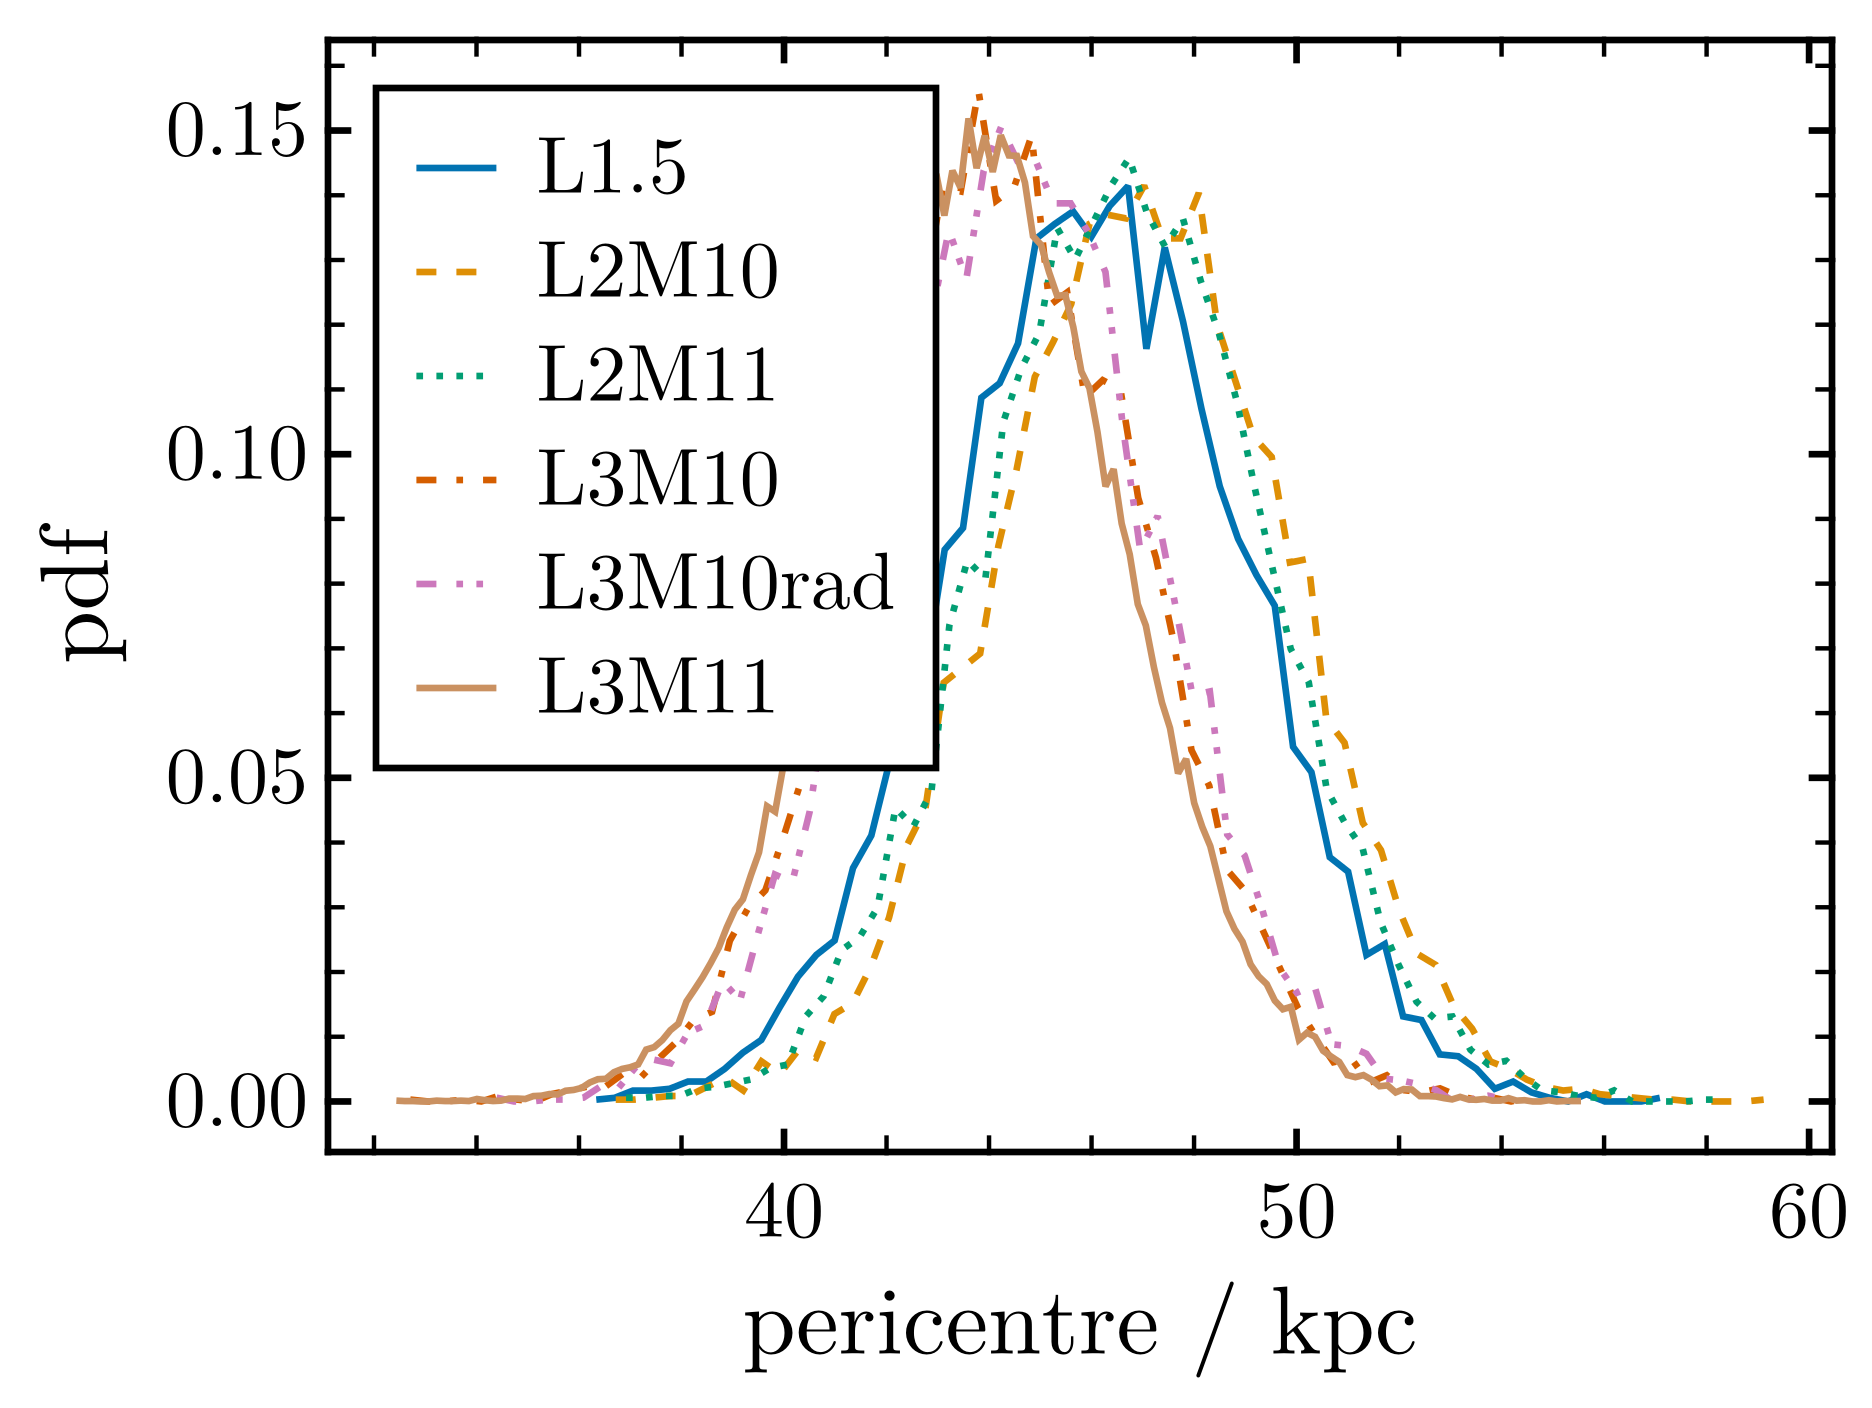

In [81]:
compare_peris(families, legend_position=:lt)

[ Info: Using default bins of size = 64
[ Info: Using default bins of size = 61
[ Info: Using default bins of size = 62
[ Info: Using default bins of size = 56
[ Info: Using default bins of size = 60
[ Info: Using default bins of size = 331


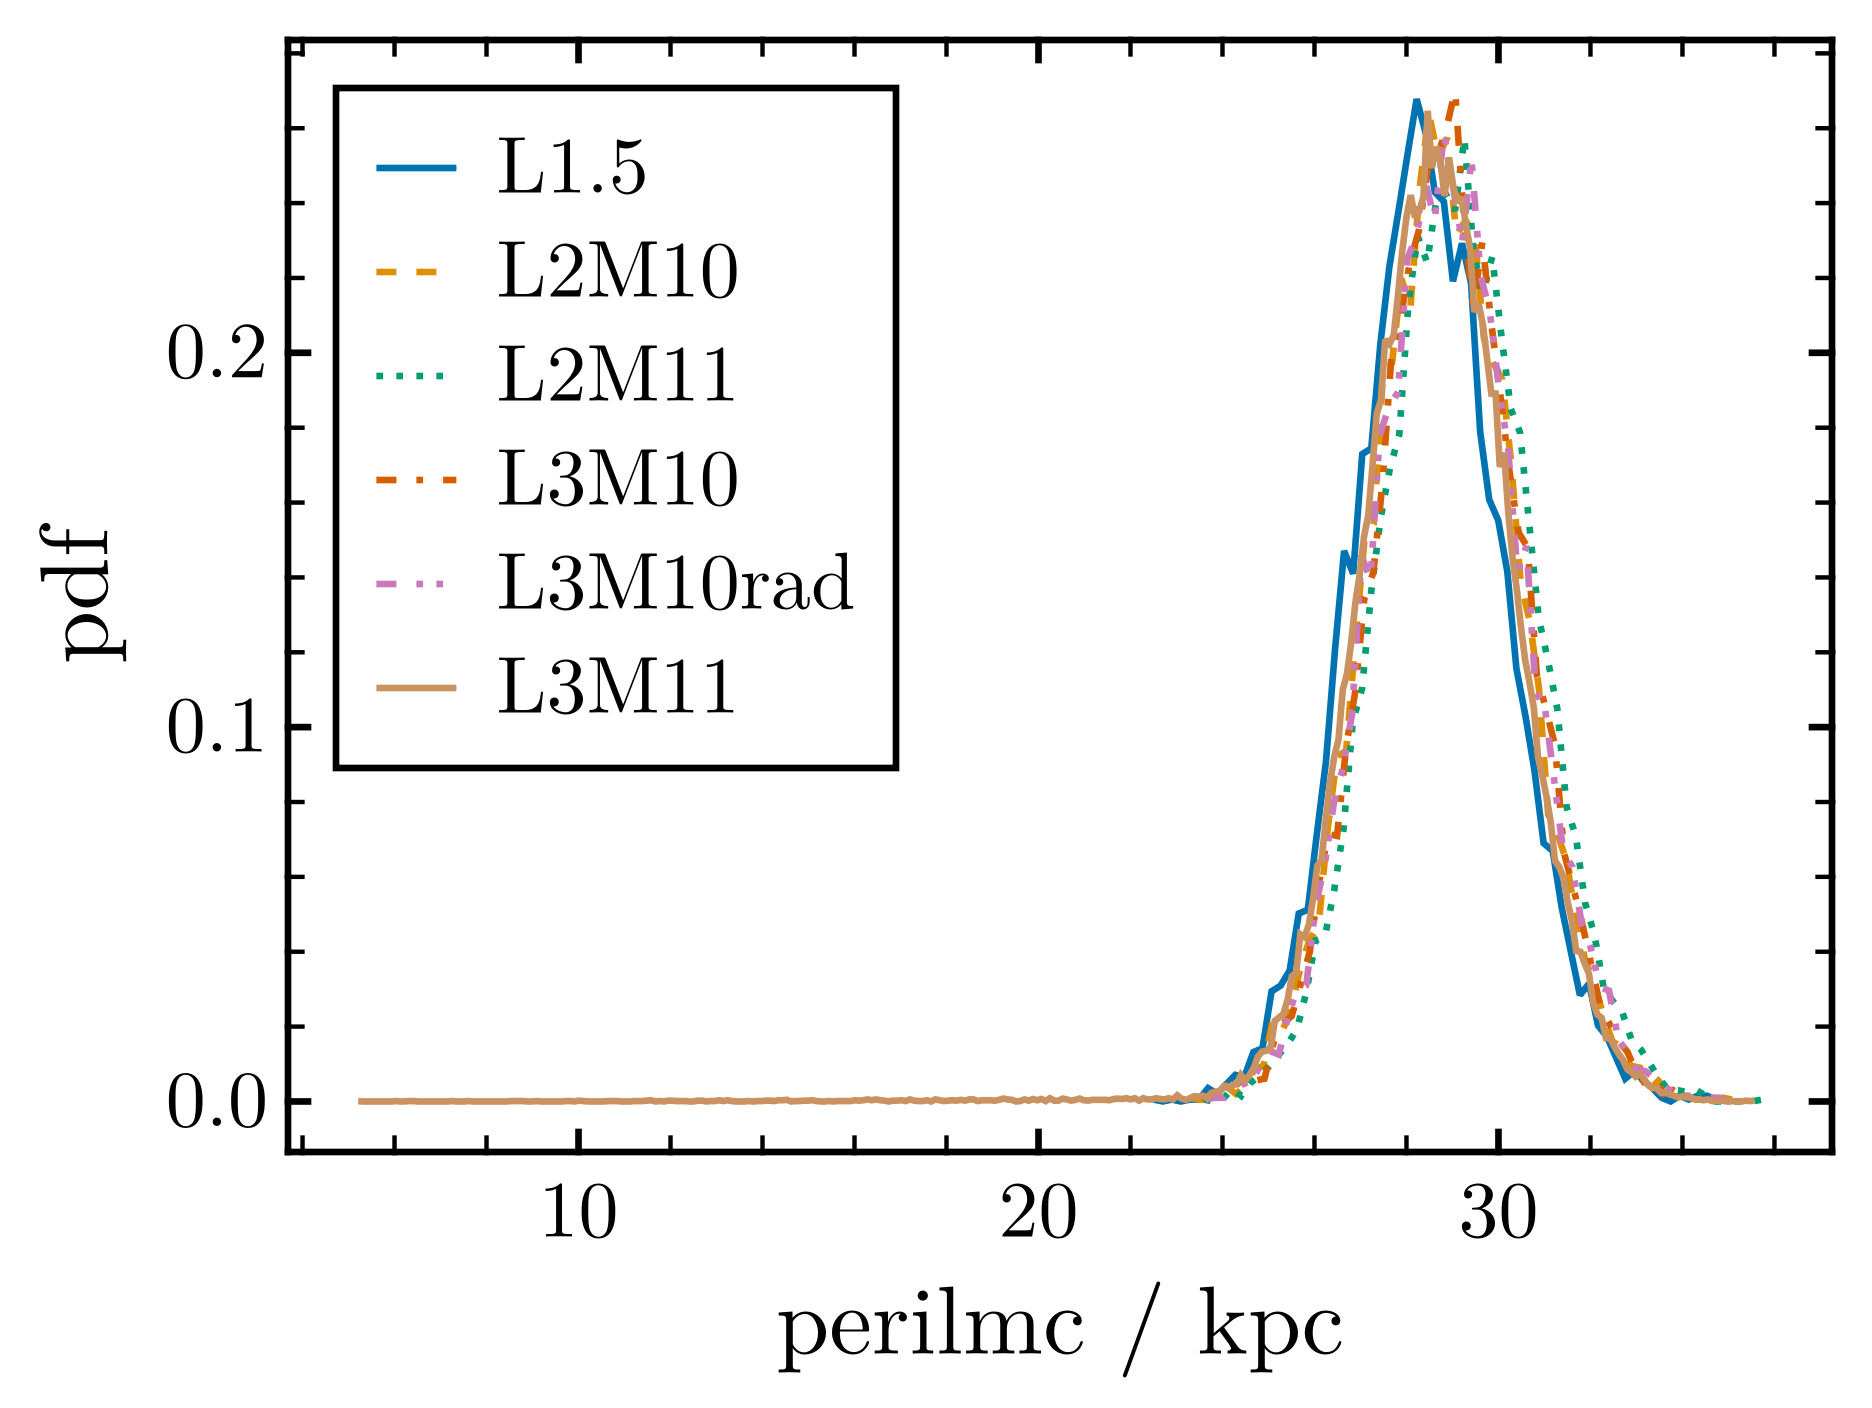

In [82]:
compare_peris(families, x="peri_lmc", legend_position=:lt)

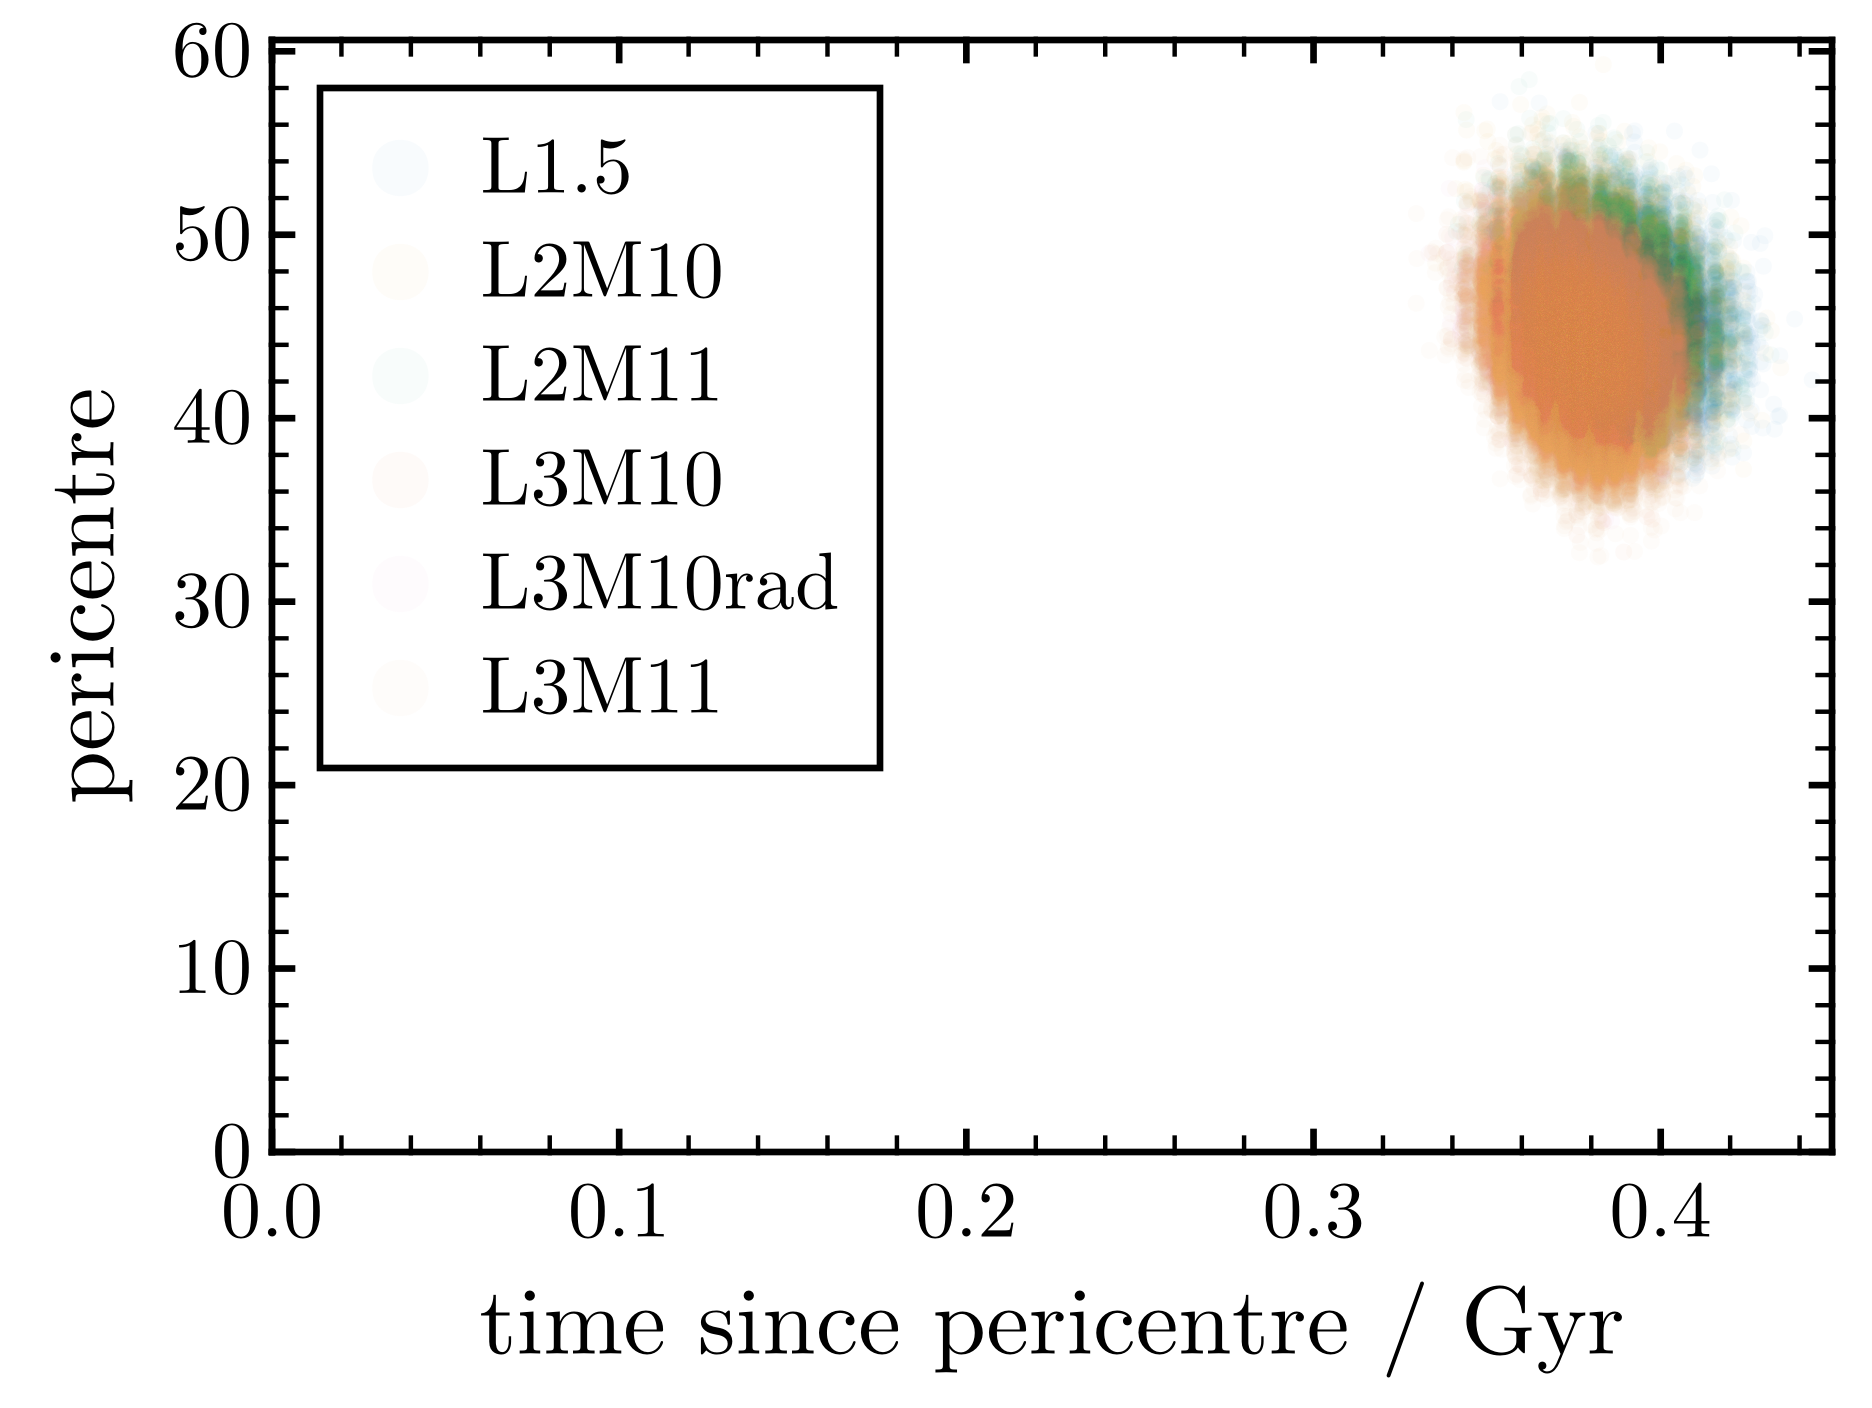

In [85]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "time since pericentre / Gyr",
    ylabel = "pericentre",
    limits=(0, nothing, 0, nothing)
)

for i in eachindex(families)
    label, df = families[i]
    scatter!(df.t_last_peri*T2GYR .+ 0.2*T2GYR * randn(length(df.t_last_peri)), df.pericentre, label=label => (; markersize=10), markersize=3, alpha=0.03, marker=:circle, color=COLORS[i])
end

axislegend(position=:lt)

fig

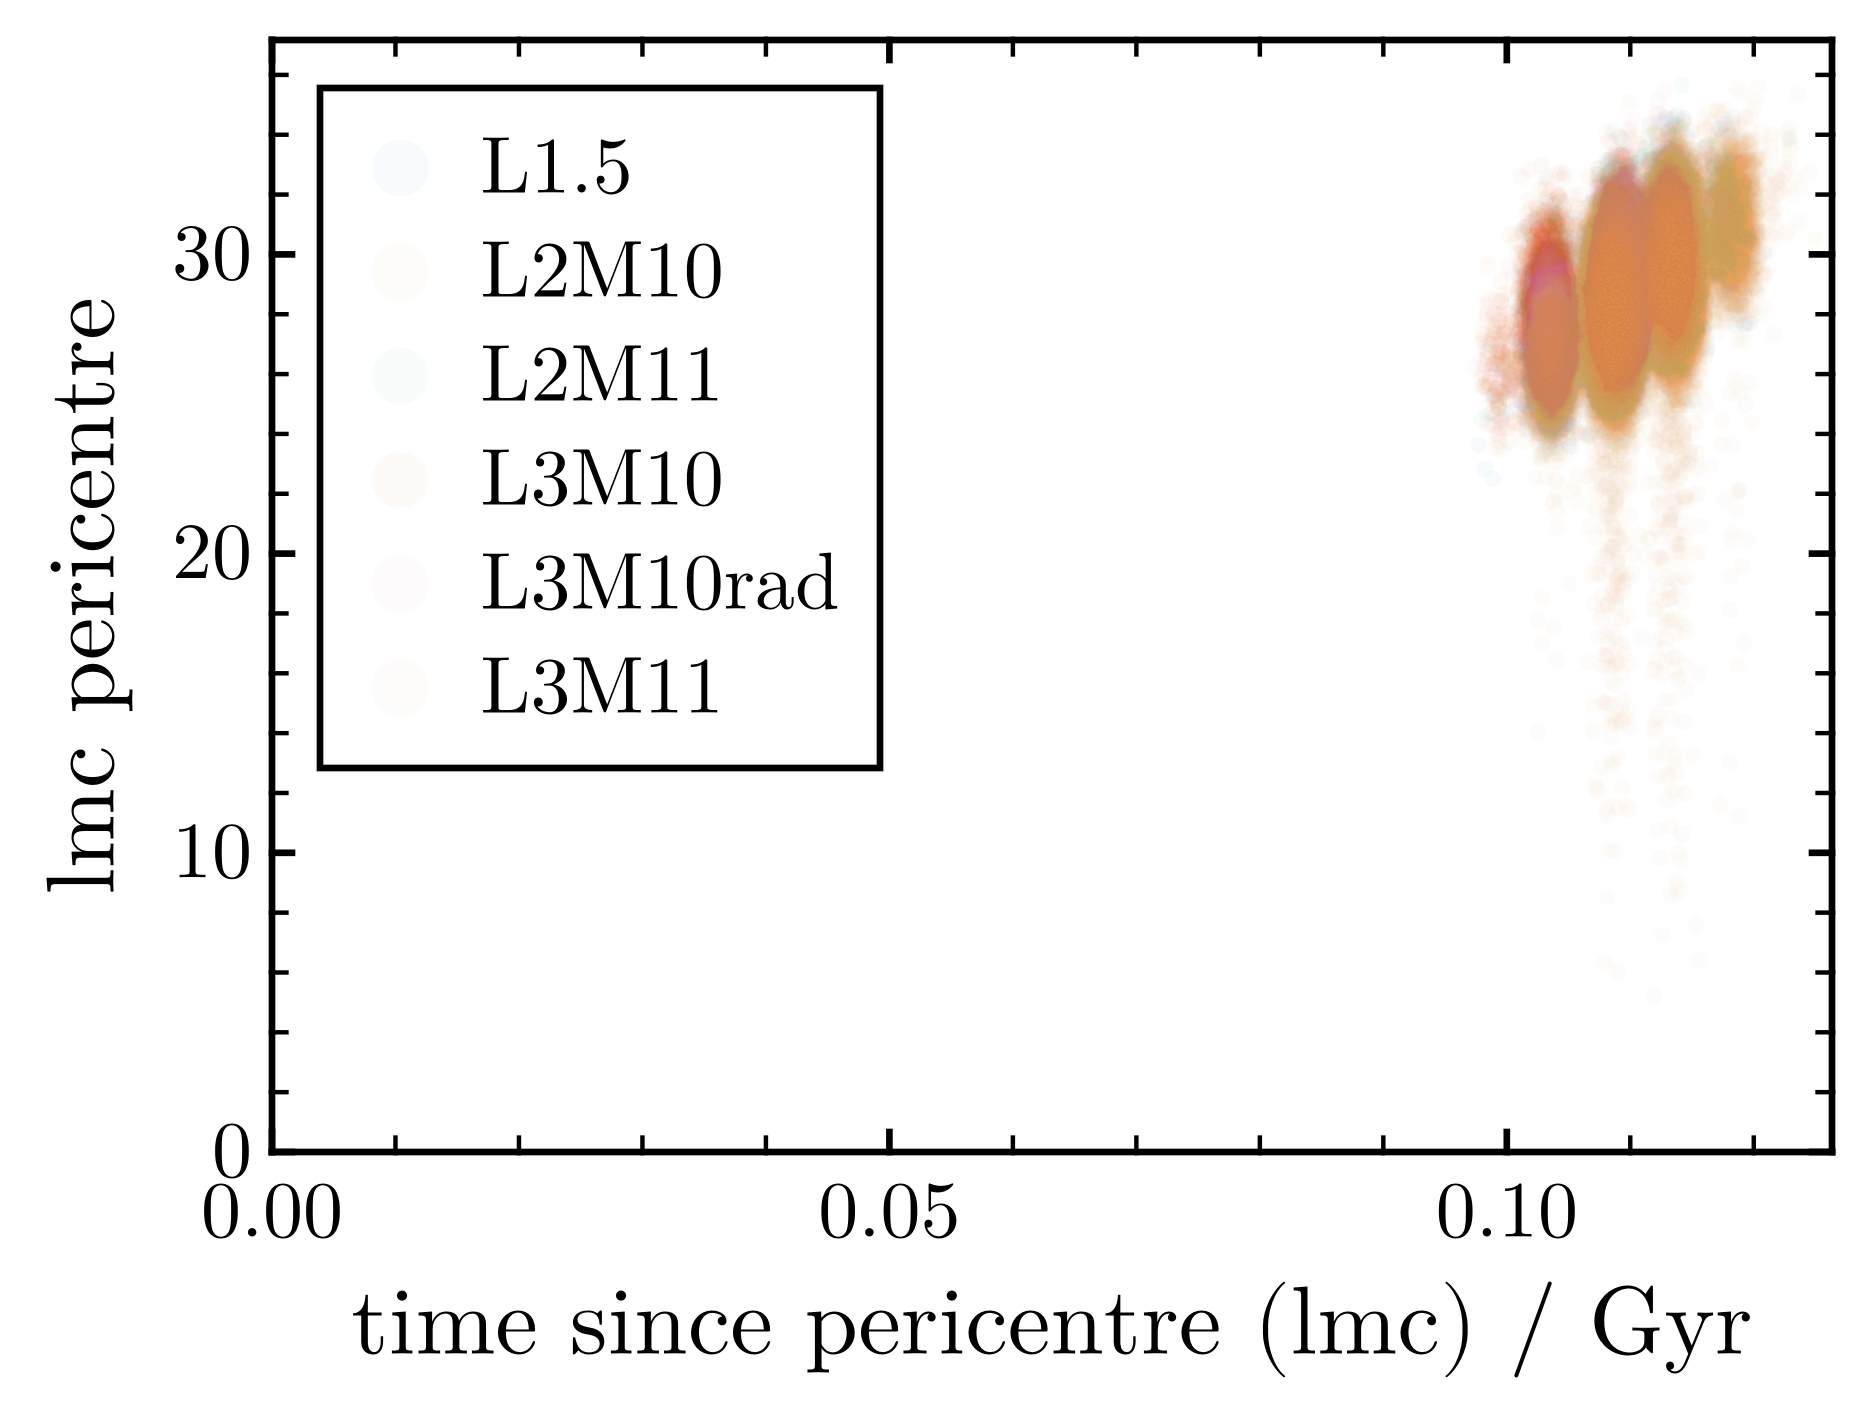

In [88]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "time since pericentre (lmc) / Gyr",
    ylabel = "lmc pericentre",
    limits=(0, nothing, 0, nothing)
)

for i in eachindex(families)
    label, df = families[i]
    scatter!(df.t_last_peri_lmc*T2GYR .+ 0.2*T2GYR * randn(length(df.t_last_peri)), df.peri_lmc, label=label => (; markersize=10), markersize=3, alpha=0.03, marker=:circle, color=COLORS[i])
end

axislegend(position=:lt)

fig

# Compare trajectories

In [89]:
traj = read_traj("vasiliev24_L3M11")

LoadError: unable to determine if vasiliev24_L3M11/trajectory.hdf5 is accessible in the HDF5 format (file may not exist)

In [91]:
traj_no = read_traj("vasiliev24_M11")

LoadError: unable to determine if vasiliev24_M11/trajectory.hdf5 is accessible in the HDF5 format (file may not exist)

In [ ]:
V_T2GYR = 0.97779

In [ ]:
# loads in trajectory of lmc in Vasiliev 2021
lmc_file = ENV["DWARFS_ROOT"] * "/agama/potentials/vasiliev+21/trajlmc.txt"
lmc_traj = CSV.read(lmc_file, DataFrame, delim=" ", header = [:time, :x, :y, :z, :v_x, :v_y, :v_z])

lmc_x = LilGuys.lerp(lmc_traj.time, lmc_traj.x)
lmc_y = LilGuys.lerp(lmc_traj.time, lmc_traj.y)
lmc_z = LilGuys.lerp(lmc_traj.time, lmc_traj.z)
lmc_v_x = LilGuys.lerp(lmc_traj.time, lmc_traj.v_x)
lmc_v_y = LilGuys.lerp(lmc_traj.time, lmc_traj.v_y)
lmc_v_z = LilGuys.lerp(lmc_traj.time, lmc_traj.v_z)

times_v = traj[3] * T2GYR / V_T2GYR
pos = reshape([lmc_x.(times_v) lmc_y.(times_v) lmc_z.(times_v)]', (3, 1, :))
vel = reshape([lmc_v_x.(times_v) lmc_v_y.(times_v) lmc_v_z.(times_v)]', (3, 1, :))

In [ ]:
fig, ax = FigAxis(xlabel="y", ylabel="z")

scatter!(lmc_traj.y, lmc_traj.z)
scatter!(pos[2, 1, :], pos[3, 1, :])

fig

In [ ]:
traj_lmc = pos, vel, traj[3]
traj_scl_lmc = pos .- traj[1], vel .- traj[2], traj[3]


In [ ]:
function plot_r_t_traj!(traj; alpha=0.01, thin=1, color=:black, kwargs...)
    positions, velocities, times = traj
    for i in 1:thin:size(positions, 2)
        x = times * T2GYR
        y = calc_r(positions[:, i, :])
        lines!(x, y; rasterize=true, alpha=alpha, color=color, kwargs...)
    
    end
end

In [ ]:
function plot_x_y_traj!(traj; thin=1, x_direction=2, y_direction=3, alpha=0.01, color=:black, kwargs...)
    positions, velocities, times = traj
    for i in 1:thin:size(positions, 2)
        x = positions[x_direction, i, :]
        y = positions[y_direction, i, :]
        
        lines!(x, y; rasterize=true, alpha=alpha, color=color, kwargs...)
    
    end
end

In [ ]:
function compare_x_y_traj(trajectories; kwargs...)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="y / kpc", ylabel="z / kpc",
        xgridvisible=false, ygridvisible=false, 
        aspect=DataAspect(),
    )
    
    for (i, (label, traj)) in enumerate(trajectories)
        plot_x_y_traj!(traj, label=label, color=COLORS[i]; kwargs...)
    end
        
    fig, ax
end

In [ ]:
function compare_r_t_traj(trajectories; kwargs...)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="time / Gyr", ylabel = "Scl galactocentric distance / kpc",
        xgridvisible=false, ygridvisible=false
    )

    for (i, (label, traj)) in enumerate(trajectories)
        plot_r_t_traj!(traj, label=label, color=COLORS[i]; kwargs...)
    end
    
    fig, ax
end

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time / Gyr", ylabel = "Scl galactocentric distance / kpc",
    xgridvisible=false, ygridvisible=false
)

plot_r_t_traj!(traj_no, label="MW only")
plot_r_t_traj!(traj, label="MW + LMC", color=COLORS[1])

axislegend(unique=true)
fig

In [ ]:
mkpath("figures")
figdir = "./figures/"

## 

In [ ]:
r2 = @. traj_scl_lmc[1][1, :, :]^2 + traj_scl_lmc[1][2, :, :]^2 + traj_scl_lmc[1][3, :, :]^2
r = sqrt.(r2)
idx_min = [argmin(row) for row in eachrow(r)]
t_scl_lmc_peri = traj_scl_lmc[3][idx_min]
r_scl_lmc_peri = [r[i, idx_min[i]] for i in 1:size(r, 1)]

In [ ]:
unique(idx_min)

In [ ]:
traj[3]

In [ ]:
traj[3][20:26]

In [ ]:
rb = LilGuys.calc_break_radius(9.4/V2KMS, 0.11 / T2GYR)

In [ ]:
LilGuys.kpc_to_arcmin(rb, 83.2)

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time of minimum / Gyr", ylabel="minimum distance (Scl-LMC) / kpc")

scatter!(t_scl_lmc_peri * T2GYR .+ 0.0003 * randn(length(t_scl_lmc_peri)), r_scl_lmc_peri)

fig

In [ ]:
V_T2GYR * 5/ T2GYR

In [ ]:
V_T2GYR * 0.25 / T2GYR

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time / Gyr", ylabel = "radius / kpc",
    xgridvisible=false, ygridvisible=false
)

plot_r_t_traj!(traj, label="Scl-MW", color=COLORS[1])
plot_r_t_traj!(traj_scl_lmc, label="Scl-LMC", color=COLORS[2])
plot_r_t_traj!(traj_lmc, label="LMC-MW", color=:black, alpha=1, linewidth=3, )


axislegend(unique=true)

Makie.save("$figdir/scl_lmc_mw_r_t_samples.pdf", fig)

fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="y / kpc", ylabel="z / kpc",
    xgridvisible=false, ygridvisible=false, 
    aspect=DataAspect(),
)
plot_x_y_traj!(traj_scl_lmc, label="+LMC", color=:black)

fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="y / kpc", ylabel="z / kpc",
    xgridvisible=false, ygridvisible=false, 
    aspect=DataAspect(),
)
plot_x_y_traj!(traj_no, label="Scl, MW only")
plot_x_y_traj!(traj, label="Scl, MW + LMC", color=COLORS[1])
plot_x_y_traj!(traj_lmc, label="LMC", alpha=1, color=COLORS[2], linewidth=3)

axislegend(unique=true)

fig

### Other trajectories

In [ ]:
using OrderedCollections

In [ ]:
trajectories = OrderedDict(
    "L1.5" => read_traj("vasiliev_lmc"),
    "L2M10" => read_traj("vasiliev24_L2M10"),
    "L2M11" => read_traj("vasiliev24_L2M11"),    
    "L3M10" => read_traj("vasiliev24_L3M10"),
    "L3M10rad" => read_traj("vasiliev24_L3M10rad"),
    "L3M11" => read_traj("vasiliev24_L3M11"),
    )

In [ ]:
lmc_trajectories = OrderedDict(
    "L1.5" => read_lmc_traj("vasiliev_lmc"),
    "L2M10" => read_lmc_traj("vasiliev24_L2M10"),
    "L2M11" => read_lmc_traj("vasiliev24_L2M11"),    
    "L3M10" => read_lmc_traj("vasiliev24_L3M10"),
    "L3M10rad" => read_lmc_traj("vasiliev24_L3M10rad"),
    "L3M11" => read_lmc_traj("vasiliev24_L3M11"),
    )

In [ ]:
scl_lmc_trajectories = OrderedDict(key => subtract_traj(trajectories[key], lmc_trajectories[key]) for key in keys(trajectories))

In [ ]:
fig, ax = compare_x_y_traj(trajectories, thin=10, alpha=0.03)

Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_x_y_traj(trajectories, x_direction=1, thin=10, alpha=0.03)

ax.xlabel = "x / kpc"
Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_x_y_traj(lmc_trajectories, alpha=1)
Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_x_y_traj(scl_lmc_trajectories, thin=10, alpha=0.03)

Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_r_t_traj(trajectories, thin=10, alpha=0.02)

Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_r_t_traj(lmc_trajectories, alpha=1)
ax.ylabel = "LMC - MW distance / kpc"
Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_r_t_traj(scl_lmc_trajectories, thin=10, alpha=0.02)

ax.ylabel = "Scl - LMC distance / kpc"
Legend(fig[1,2], ax, unique=true)
fig